# <font color='darkgreen'>DATA SCIENCE EM MARKETING</font>
## <font color='darkgreen'>SEGMENTAÇÃO DE CLIENTES</font>
## <font color='darkgreen'>Machine Learning - Estatística - Análise e Visualização de Dados</font>

Este Projeto envolve o uso de aprendizado não supervisionado para a segmentação de clientes, com o objetivo de encontrar grupos similares e ajudar a equipe de Marketing a compreender como orientar melhor as campanhas, de acordo com o perfil dos clientes. 

## Instalar e Carregar Pacotes

In [1]:
# Usado para resolver bug do K-Means
!pip install -q threadpoolctl==3.5.0

In [2]:
# Importar pacotes

# Manipulação de dados
import numpy as np
import pandas as pd

# Estatística e Machine Learning
from scipy import stats
import threadpoolctl
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Gravar versões de pacotes
!pip install -q -U watermark

In [4]:
# Versões dos pacotes
%reload_ext watermark
%watermark --iversions

sklearn      : 1.3.0
scipy        : 1.11.1
pandas       : 2.0.3
numpy        : 1.24.3
seaborn      : 0.12.2
threadpoolctl: 3.5.0
matplotlib   : 3.7.2



## Carregar Dados

In [5]:
# Garantir reprodutibilidade
np.random.seed(42)

In [6]:
# Carregar dataset
df = pd.read_csv('dataset.csv')

In [7]:
# Shape
df.shape

(150, 6)

In [8]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Idade                150 non-null    int64  
 1   Gasto_Mensal         150 non-null    float64
 2   Tempo_de_Assinatura  150 non-null    int64  
 3   Taxa_de_Uso          150 non-null    float64
 4   Suporte_Tickets      150 non-null    int64  
 5   Cancelou             150 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 7.2 KB


In [9]:
# Dados iniciais
df.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,48,166.0,13,0.524262,2,1
1,37,210.0,13,0.628494,2,0
2,31,242.0,17,0.706550,1,0
3,30,169.0,12,0.517458,3,0
4,44,202.0,15,0.774564,3,0


In [10]:
# Dados aleatórios
df.sample(10)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
73,64,284.0,18,0.842593,2,1
18,28,64.0,3,0.110168,1,0
118,37,210.0,13,0.628494,2,0
78,58,246.0,22,0.878449,2,1
76,53,296.0,20,0.870118,2,1
31,27,103.0,7,0.164489,2,0
64,46,217.0,16,0.602564,1,1
141,34,213.0,17,0.536049,7,1
68,55,282.0,19,0.826803,2,1
82,60,299.0,18,0.902798,2,1


## Análise Exploratória e Limpeza de Dados

In [11]:
# Verificar valores nulos
print(df.isnull().sum())

Idade                  0
Gasto_Mensal           0
Tempo_de_Assinatura    0
Taxa_de_Uso            0
Suporte_Tickets        0
Cancelou               0
dtype: int64


O algoritmo KMeans pode ser impactado por valores outliers e pela correlação entre as variáveis, pois utiliza a distância euclidiana entre os pontos para formar clusters e o cálcuo de distância, vamos usar boxplot e uma matriz de correlação para analisar os dados.

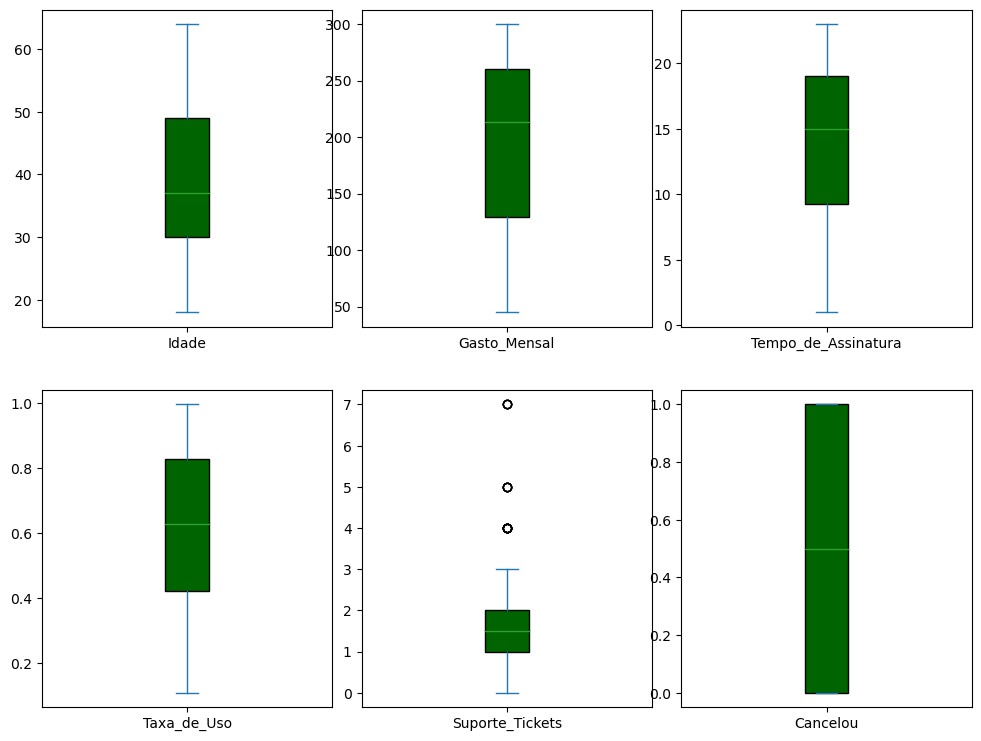

In [12]:
# Plotar boxplots
df.plot(subplots=True, layout=(3,3), kind='box', figsize=(12,14), patch_artist=True,
            boxprops=dict(facecolor='#006400'))

# Ajustar espaçamento
plt.subplots_adjust(wspace=0.1)

In [13]:
# Observe que a variável cancelou é categórica
df.Cancelou.value_counts()

Cancelou
1    75
0    75
Name: count, dtype: int64

### Identificar os outliers

In [14]:
# Definir o Intervalo Interquartil
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [15]:
# Verificar os valores que estão acima ou abaixo do IQR
outliers = ((df < (Q1 - 2.5 * IQR)) | (df > (Q3 + 2.5 * IQR))).any(axis = 1)

In [16]:
# Filtrar os outliers
df_outliers = df[outliers]

In [17]:
# Visualizar os outliers
df_outliers

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
12,46,227.0,16,0.697133,5,0
53,48,172.0,12,0.619646,7,1
54,43,205.0,13,0.630056,5,0
63,34,213.0,17,0.536049,7,1
95,53,300.0,23,0.865750,5,1
96,48,300.0,21,0.926680,5,1
119,34,213.0,17,0.536049,7,1
140,43,205.0,13,0.630056,5,0
141,34,213.0,17,0.536049,7,1


Identificados os outliers vamos, tratar deles logo à frente!

In [18]:
# Calcular a matriz de correlação
correlation_matrix = df.corr()

In [19]:
correlation_matrix

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
Idade,1.000000,0.852082,0.796329,0.838483,0.392994,0.509760
Gasto_Mensal,0.852082,1.000000,0.909784,0.905781,0.354883,0.565705
Tempo_de_Assinatura,0.796329,0.909784,1.000000,0.863953,0.404463,0.639020
Taxa_de_Uso,0.838483,0.905781,0.863953,1.000000,0.354725,0.545604
Suporte_Tickets,0.392994,0.354883,0.404463,0.354725,1.000000,0.255737
Cancelou,0.509760,0.565705,0.639020,0.545604,0.255737,1.000000


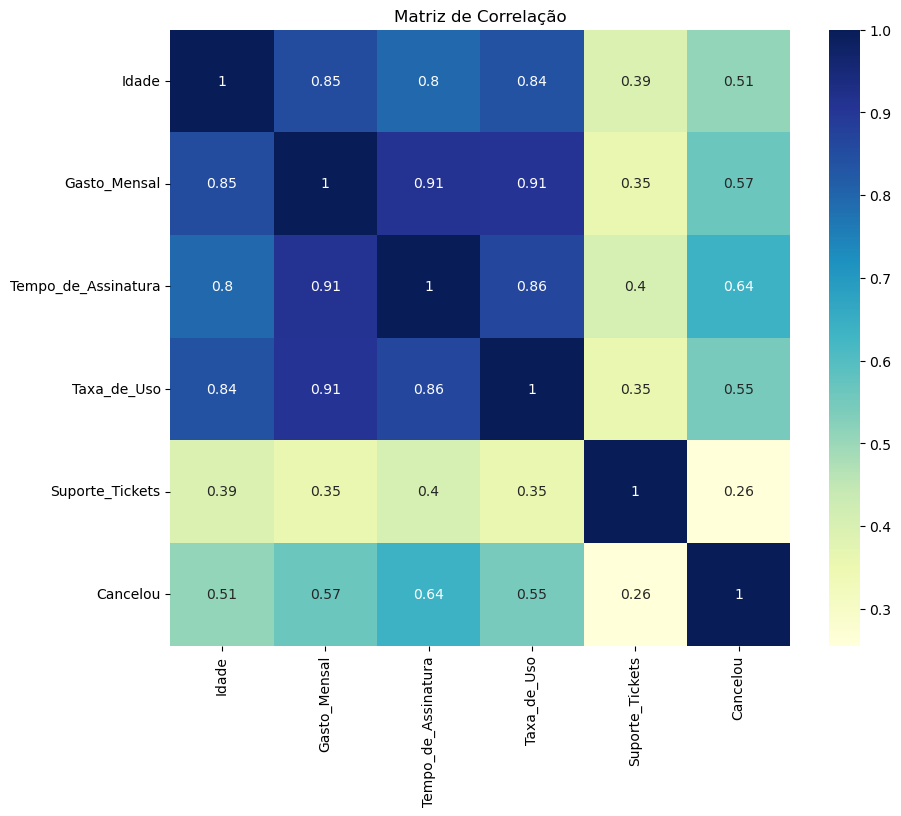

In [20]:
# Plot
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'YlGnBu')
plt.title('Matriz de Correlação')
plt.show()

In [21]:
# Criar o padronizador
scaler = StandardScaler()

In [22]:
# Padronizando as Variáveis
df_pd = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

## Definir o Valor de K em Modelos de Clusterização


### Método Elbow

O Método do Cotovelo é uma técnica usada para determinar o número ideal de grupos em uma análise de cluster, como o K-means.
O gráfico resultante ajuda a identificar o ponto onde a redução na inércia começa a diminuir significativamente. Este ponto é considerado o número ideal de clusters para o de dados.

In [23]:
# Lista para armazenar o SSE
sse = []

In [24]:
# Range de valores de k a serem testados
k_range = range(1, 11)

In [25]:
# Usando o Kmeans para testar 10 modelos
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_pd)
    sse.append(kmeans.inertia_)

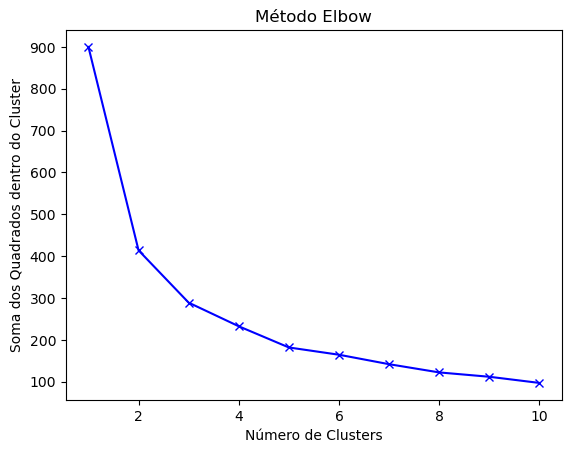

In [26]:
# Plot
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados dentro do Cluster')
plt.title('Método Elbow')
plt.show()

O gráfico do método Elbow sugere um ponto de inflexão em torno de 3 a 4 clusters.

### Método da Silhueta 

O Método da Silhueta é outra técnica usada para determinar o número ideal de clusters em uma análise de cluster. Ele avalia a qualidade dos clusters medindo quão semelhantes os pontos dentro de um cluster são uns aos outros (coesão) em comparação com os pontos de outros clusters (separação). A pontuação da silhueta varia de -1 a 1, onde valores próximos a 1 indicam que os pontos estão bem agrupados, valores próximos a 0 indicam que os pontos estão na fronteira entre dois clusters, e valores negativos indicam que os pontos podem ter sido atribuídos ao cluster errado.

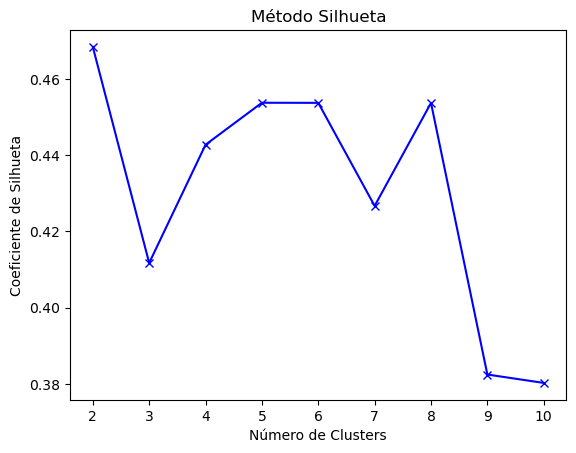

In [27]:
# Lista para o Silhouette score
sil_score = []

# Loop pelo range de valores de k a serem testados
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_pd)
    
    # Silhouette score não é definido para k = 1, então filtramos
    if k != 1:
        sil_score.append(silhouette_score(df_pd, kmeans.labels_))

# Plot
plt.plot(k_range[1:], sil_score, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método Silhueta')
plt.show()

## Construir a Primeira Versão do Modelo de Clusterização

In [28]:
# Modelo com 4 clusters
modelo_kmeans = KMeans(n_clusters = 4, random_state = 42)

In [29]:
# Treinar o modelo e salvar o resultado em uma coluna do df original
df['cluster'] = modelo_kmeans.fit_predict(df_pd)

In [30]:
# Amostra aleatória de dados
df.sample(10)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
5,30,232.0,13,0.632706,2,0,3
13,24,121.0,11,0.324511,2,0,1
91,48,259.0,20,0.851649,1,1,0
82,60,299.0,18,0.902798,2,1,0
100,52,246.0,19,0.891827,1,1,0
109,52,291.0,19,0.989904,4,1,0
104,21,92.0,11,0.112572,0,1,1
105,60,299.0,18,0.902798,2,1,0
98,53,287.0,23,0.815173,2,1,0
84,56,277.0,21,0.879309,2,1,0


In [31]:
df.shape

(150, 7)

In [32]:
# Usar o dataset original, incluindo os outliers
df_limpo = df

In [33]:
df_limpo.shape

(150, 7)

### PairGrid

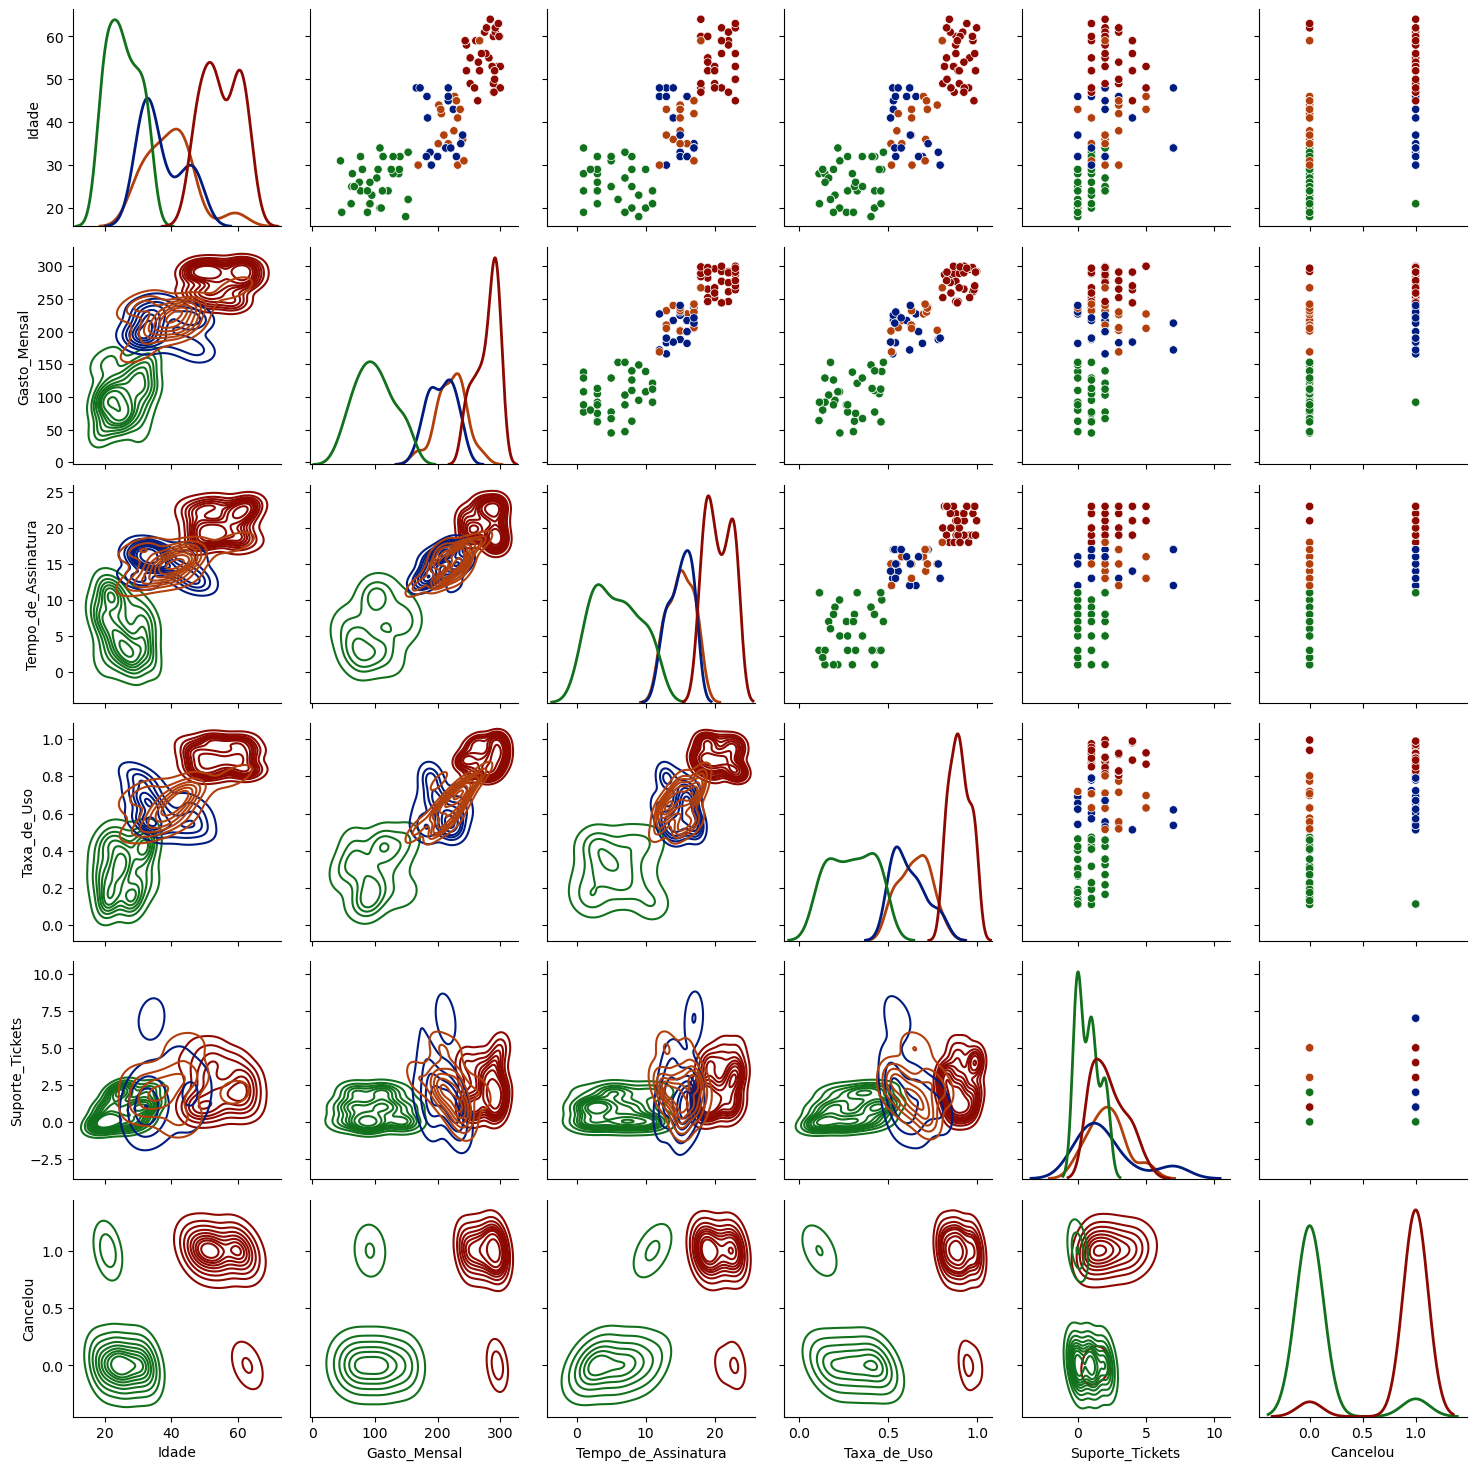

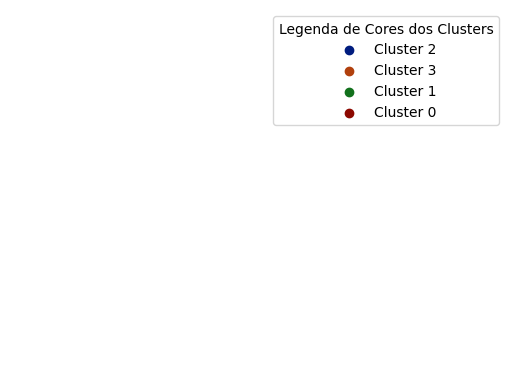

In [34]:
# Criar um mapa de cores
palette = sns.color_palette('dark', n_colors = len(df_limpo['cluster'].unique()))
color_map = dict(zip(df_limpo['cluster'].unique(), palette))

# Plot
g = sns.PairGrid(df_limpo, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Visualizar o mapa de cores
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

## Construir a Segunda Versão do Modelo de Clusterização

In [35]:
# Modelo com 3 clusters
modelo_kmeans = KMeans(n_clusters = 3, random_state = 42)

In [36]:
df.drop('cluster', axis = 1, inplace = True)

In [37]:
df.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,48,166.0,13,0.524262,2,1
1,37,210.0,13,0.628494,2,0
2,31,242.0,17,0.706550,1,0
3,30,169.0,12,0.517458,3,0
4,44,202.0,15,0.774564,3,0


In [38]:
# Treinar o modelo e salvar o resultado em uma coluna do dataframe original
df['cluster'] = modelo_kmeans.fit_predict(df_pd)

In [39]:
# Amostra aleatória de dados
df.sample(10)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
135,32,200.0,16,0.669811,2,1,0
113,41,184.0,14,0.512320,4,1,0
85,54,265.0,19,0.924417,3,1,1
4,44,202.0,15,0.774564,3,0,0
6,34,221.0,17,0.571936,1,1,0
107,62,278.0,23,0.827274,3,1,1
104,21,92.0,11,0.112572,0,1,2
60,35,201.0,15,0.514315,2,0,0
33,32,140.0,8,0.423248,2,0,2
39,26,75.0,3,0.315737,1,0,2


In [40]:
# Mantém apenas as linhas que não são outliers
df_limpo = df[~outliers]

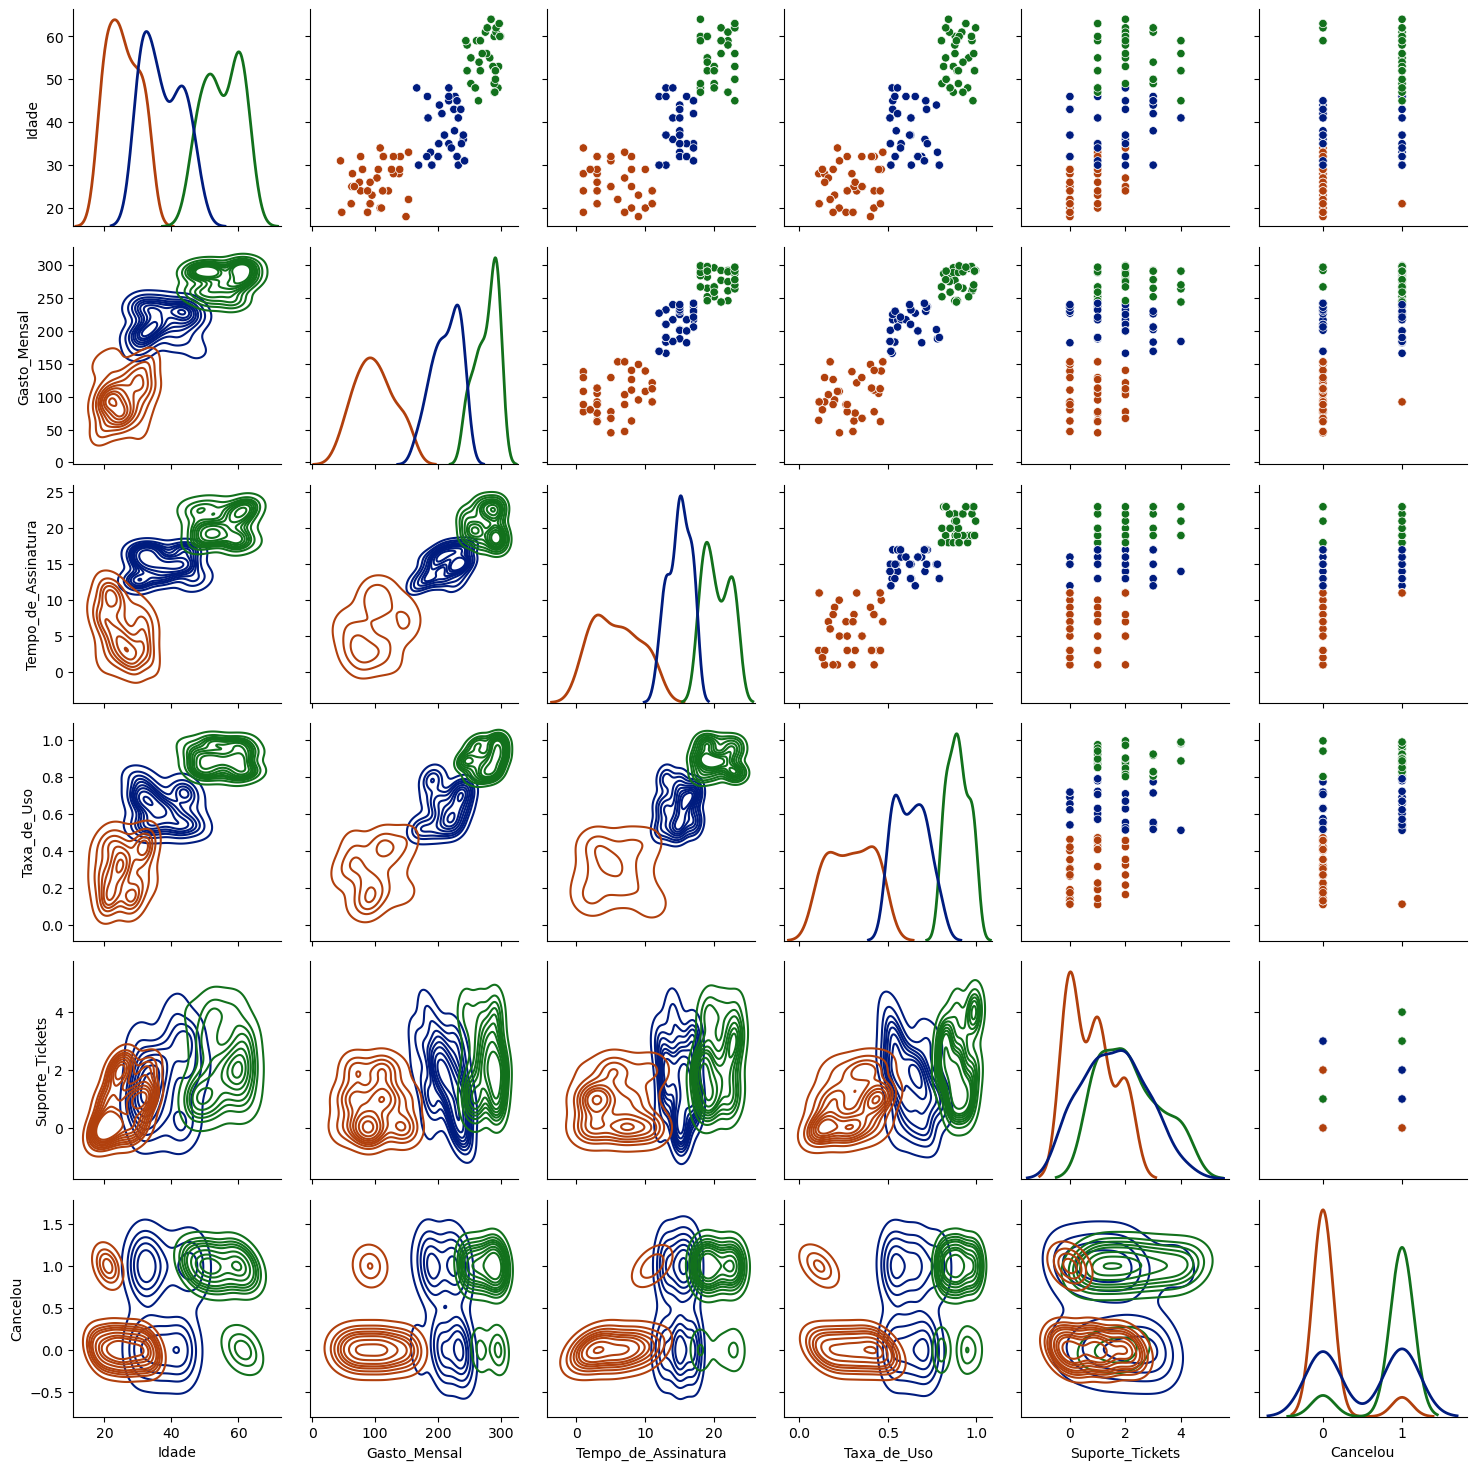

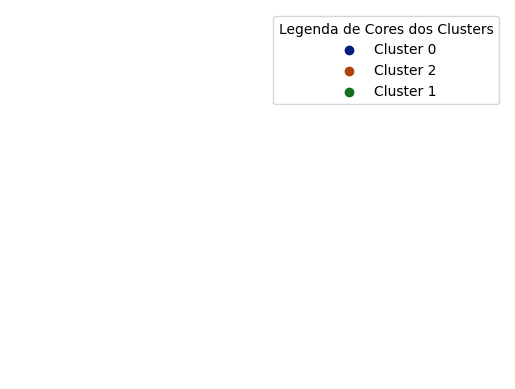

In [41]:
# Criar um mapa de cores
palette = sns.color_palette('dark', n_colors = len(df_limpo['cluster'].unique()))
color_map = dict(zip(df_limpo['cluster'].unique(), palette))

# Plot
g = sns.PairGrid(df_limpo, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Visualizar o mapa de cores
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

## Análise dos Clusters

In [42]:
df_limpo[df_limpo.cluster == 0].head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
0,48,166.0,13,0.524262,2,1,0
1,37,210.0,13,0.628494,2,0,0
2,31,242.0,17,0.706550,1,0,0
3,30,169.0,12,0.517458,3,0,0
4,44,202.0,15,0.774564,3,0,0


In [43]:
df_limpo[df_limpo.cluster == 0].mean()

Idade                   37.346939
Gasto_Mensal           212.979592
Tempo_de_Assinatura     14.959184
Taxa_de_Uso              0.631508
Suporte_Tickets          1.612245
Cancelou                 0.510204
cluster                  0.000000
dtype: float64

In [44]:
df_limpo[df_limpo.cluster == 1].head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
66,59,261.0,22,0.975331,1,1,1
67,60,289.0,19,0.880697,1,1,1
68,55,282.0,19,0.826803,2,1,1
69,49,252.0,20,0.805757,3,1,1
70,48,295.0,18,0.951027,1,1,1


In [45]:
df_limpo[df_limpo.cluster == 1].mean()

Idade                   55.266667
Gasto_Mensal           277.333333
Tempo_de_Assinatura     20.422222
Taxa_de_Uso              0.896845
Suporte_Tickets          2.155556
Cancelou                 0.888889
cluster                  1.000000
dtype: float64

In [46]:
df_limpo[df_limpo.cluster == 2].head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
13,24,121.0,11,0.324511,2,0,2
14,32,113.0,3,0.408387,1,0,2
15,28,138.0,1,0.297518,0,0,2
16,25,63.0,8,0.309093,0,0,2
17,24,88.0,3,0.271016,0,0,2


In [47]:
df_limpo[df_limpo.cluster == 2].mean()

Idade                  25.574468
Gasto_Mensal           99.297872
Tempo_de_Assinatura     5.808511
Taxa_de_Uso             0.293689
Suporte_Tickets         0.765957
Cancelou                0.085106
cluster                 2.000000
dtype: float64

### Centróides 

Os centroides são os pontos médios dos clusters que representam as "médias" ou "centros" dos dados agrupados em cada cluster.Eles fornecem uma maneira de resumir as características principais de cada cluster e são úteis para entender a distribuição e a variação dos dados dentro dos clusters.

In [48]:
# Extraindo os centróides
centroides = modelo_kmeans.cluster_centers_

In [49]:
centroides

array([[-0.12659068,  0.19441009,  0.17994096,  0.07841257,  0.26781213,
         0.03571429],
       [ 1.21886157,  1.06990866,  1.05386044,  1.13064915,  0.33154555,
         0.78723404],
       [-1.06803012, -1.30154621, -1.26825818, -1.22407689, -0.65064085,
        -0.82978723]])

Cada linha representa um cluster com as seis variáveis (colunas).

### Plot dos Clusters

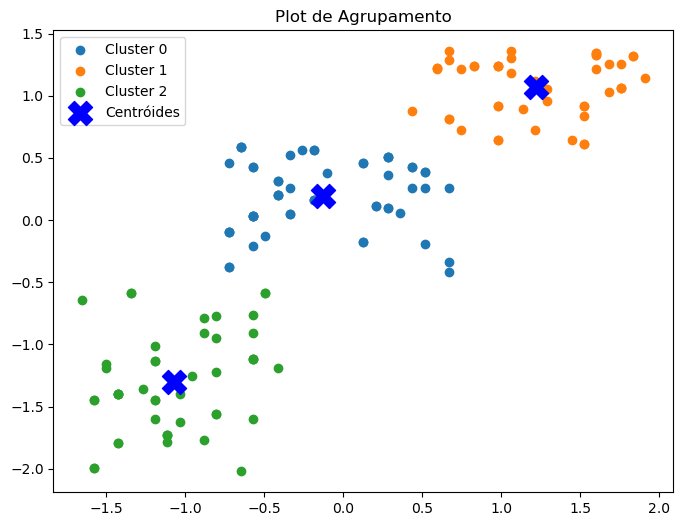

In [50]:
# Cria a figura
plt.figure(figsize = (8, 6))

# Loop pelos clusters
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_pd[mask].iloc[:, 0], df_pd[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

# Plot
plt.scatter(modelo_kmeans.cluster_centers_[:, 0], 
            modelo_kmeans.cluster_centers_[:, 1], 
            s = 300, 
            c = 'blue', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Plot de Agrupamento")
plt.show()

**Interpretação**:


**Cluster 0**: Média de Idade: 37 anos; Gasto Mensal: 213 reais; Tempo de Assinatura: 15 meses; Taxa de Uso: 0.63; 
Suporte Tickets: 1.6 e Cancelamento: 51%.

O Cluster 0 (primeira linha dos centróides) contém em sua maioria clientes de ambos os grupos, cancelou e não cancelou. Observe que os valores estão próximos de 0, o que sugere que este cluster pode estar centrado próximo à média do conjunto de dados. Esse é o grupo intermediário.


**Cluster 1**: Média de Idade: 55 anos; Gasto Mensal: 277 reais; Tempo de Assinatura: 20 meses; Taxa de Uso: 0.90;
Suporte Tickets: 2.16 e Cancelamento: 89%

O Cluster 1 (segunda linha) contém em sua maioria clientes do grupo que cancelou a assinatura. Os valores são positivos e superiores a 1 para a maioria das dimensões, o que sugere que as observações neste cluster têm valores superiores à média para estas dimensões.


**Cluster 2**: Média de Idade: 26 anos; Gasto Mensal: 99 reais; Tempo de Assinatura: 6 meses; Taxa de Uso: 0.29
Suporte Tickets: 0.77 e Cancelamento: 9%

O Cluster 2 (terceira linha) contém em sua maioria clientes do grupo que não cancelou a assinatura. Os valores são negativos e inferiores a -1 para a maioria das dimensões, o que sugere que as observações neste cluster têm valores inferiores à média para estas dimensões.

Veja quantas observações foram atribuídas a cada cluster para entender o tamanho deles.

In [51]:
df['cluster'].value_counts()

cluster
0    56
2    47
1    47
Name: count, dtype: int64

## Métrica da Qualidade dos Clusters

### Análise de Silhueta

A Análise do Método Silhueta é uma técnica utilizada para avaliar a qualidade do agrupamento em análises de cluster. Ela ajuda a determinar o quão bem cada ponto foi agrupado e quão apropriado é o número de clusters escolhido

Interpretação do Método Silhueta
Coeficiente de Silhueta (Silhouette Score):

Cada ponto de dados tem um valor de silhueta que varia de -1 a 1.
Um valor de silhueta próximo a 1 indica que o ponto está bem dentro de seu próprio cluster e longe de outros clusters.
Um valor próximo de 0 indica que o ponto está na fronteira ou sobreposição de dois clusters.
Um valor negativo indica que o ponto pode ter sido agrupado no cluster errado.

In [52]:
df.groupby('cluster').mean()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
cluster,,,,,,
0,37.714286,212.214286,14.964286,0.627303,2.178571,0.517857
1,55.063830,278.297872,20.489362,0.896818,2.276596,0.893617
2,25.574468,99.297872,5.808511,0.293689,0.765957,0.085106


In [53]:
score = silhouette_score(df_pd, df['cluster'])
print(score)

0.41171498741068485
